In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=15
diffusion="5.0percent"
# diffusion="0.1percent"
# file_id = "1"
file_id = "2954"
# file_id = "2638"


# hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_5.0percent_smear_3273_1.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,20985000,524.575012,28.776987,124.380753,0.000074
1,20985000,524.548035,31.485611,124.528938,0.004687
2,20985000,529.095703,30.907675,128.522736,0.000074
3,20985000,523.641113,28.530880,128.811050,0.023610
4,20985000,523.204407,31.749161,129.115723,0.462297
...,...,...,...,...,...
10873,20985059,-138.245743,-659.412109,1717.046265,0.001910
10874,20985059,-138.098022,-665.070007,1717.059204,0.006870
10875,20985059,-138.725021,-672.616821,1717.734131,0.000273
10876,20985059,-144.862320,-672.259094,1718.242310,0.000074


[20985000 20985001 20985002 20985003 20985004 20985005 20985006 20985007
 20985008 20985009 20985010 20985011 20985012 20985013 20985014 20985015
 20985016 20985017 20985018 20985019 20985020 20985021 20985022 20985023
 20985024 20985025 20985026 20985027 20985028 20985029 20985030 20985031
 20985032 20985033 20985034 20985035 20985036 20985037 20985038 20985039
 20985040 20985041 20985042 20985043 20985044 20985045 20985046 20985047
 20985048 20985049 20985050 20985051 20985052 20985053 20985054 20985055
 20985056 20985057 20985058 20985059]


In [29]:
eid=320000
eid=event_list[12]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
548,20985011,178.454987,543.133911,511.439819,0.034026
549,20985011,175.991776,542.220642,512.329346,0.008854
550,20985011,174.311737,541.790100,512.844299,0.022122
551,20985011,172.310654,541.309875,513.073303,0.013392
552,20985011,170.127548,541.318542,513.312256,0.016938
...,...,...,...,...,...
606,20985011,128.499039,529.350342,586.800537,0.058751
607,20985011,131.118973,531.577576,588.864136,0.016988
608,20985011,129.195938,528.040588,591.030762,0.320738
609,20985011,132.202988,529.397156,594.170837,0.025023


In [30]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf, Tortuosity_dist  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  0.258 mm/sqrt(cm)
Energy threshold is:  1.0 keV
diffision scale factor is:  5
Radius scale factor is:  7
Voxel scale factor is:  2.1
Tortuosity distance scale is: 23.333333333333332


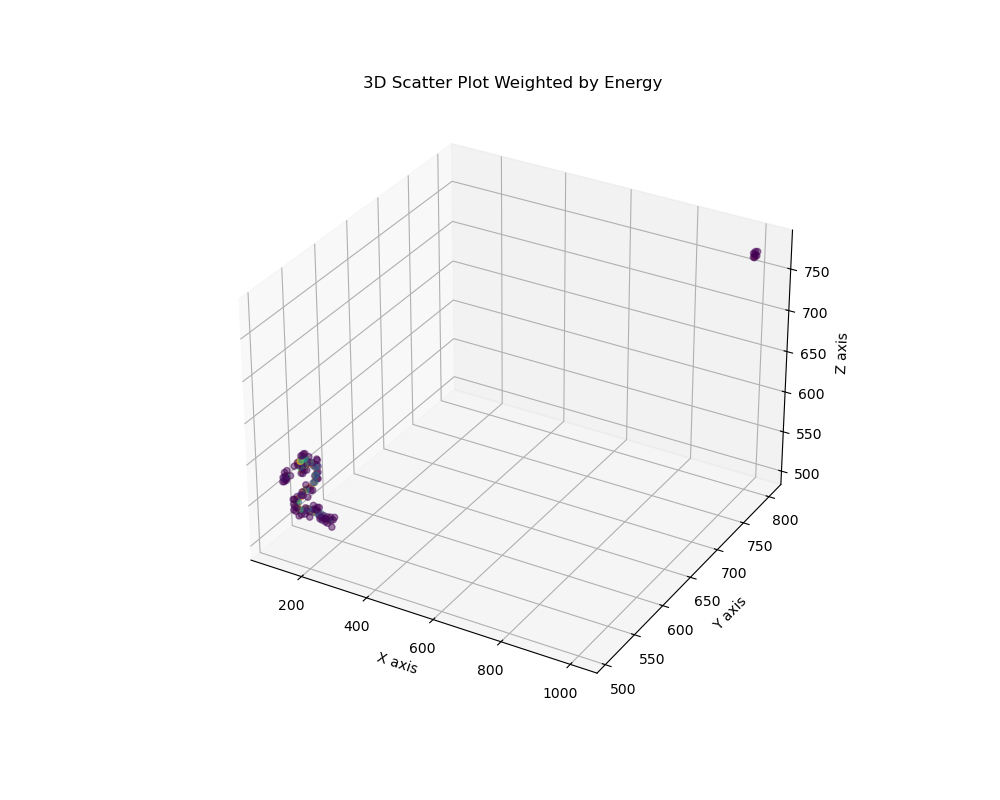

In [31]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [32]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(data)

,event_id,x,y,z,energy
0,20985011,108.120094,507.590759,574.090515,0.000074
1,20985011,108.244141,508.130219,578.884827,0.000422
2,20985011,108.329941,511.336761,578.594421,0.002827
3,20985011,108.443245,511.241119,574.212219,0.000174
4,20985011,112.040207,508.022797,574.363708,0.000918
...,...,...,...,...,...
112,20985011,1005.905273,800.945557,771.362244,0.006820
113,20985011,1009.875366,796.693909,771.773132,0.000471
114,20985011,1009.940247,802.272461,775.890808,0.000124
115,20985011,1010.015686,800.961731,771.647461,0.001017


,event_id,x,y,z,energy
0,20985011,108.120094,507.590759,574.090515,0.000074
1,20985011,108.244141,508.130219,578.884827,0.000422
2,20985011,108.329941,511.336761,578.594421,0.002827
3,20985011,108.443245,511.241119,574.212219,0.000174
4,20985011,112.040207,508.022797,574.363708,0.000918
...,...,...,...,...,...
112,20985011,1005.905273,800.945557,771.362244,0.006820
113,20985011,1009.875366,796.693909,771.773132,0.000471
114,20985011,1009.940247,802.272461,775.890808,0.000124
115,20985011,1010.015686,800.961731,771.647461,0.001017


Mean z: 566.4017  diffusion =  10
Mean Sigma:  10
Total groups created: 2


,x,y,z,energy,group_id
0,112.434723,511.216064,578.906006,0.107498,0
1,117.352257,522.508362,540.321655,0.208317,0
2,117.895538,526.547180,585.117676,0.337046,0
3,122.019485,530.862061,547.091614,0.131370,0
4,123.559875,521.009399,531.482666,0.105081,0
5,125.430046,532.860046,578.990601,0.247788,0
6,130.706009,530.659363,595.738770,0.305001,0
7,130.087433,546.606079,569.069458,0.155889,0
8,130.093399,546.246338,552.936829,0.232364,0
9,130.662155,530.704956,529.023621,0.087439,0


16 2.3548592310398817


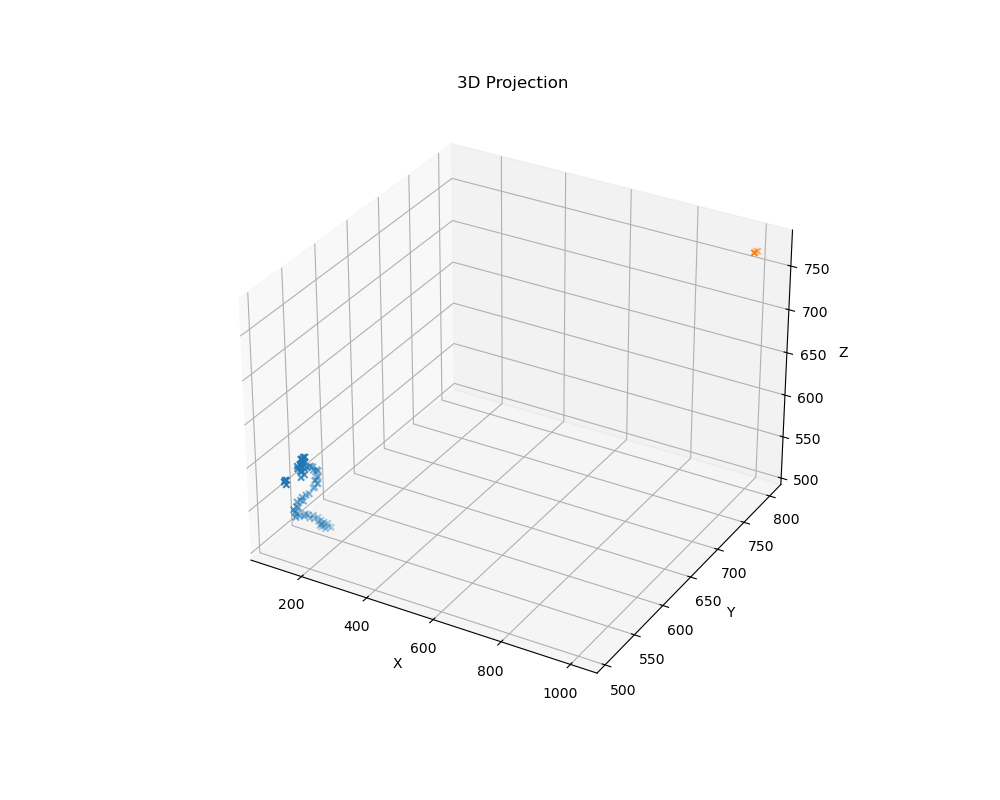

In [33]:

display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

data_copy = data.copy()
df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, threshold)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(df_merged.group_id.unique()) > 10):
    print("Running grouping again")
    df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, voxel_size*(voxel_sf+1))

df_merged = CutandRedistibuteEnergy(df_merged, energy_threshold)


# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(df_merged.group_id.unique()):
    # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = df_merged[df_merged.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



In [34]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,20985011.0,114.0,514.0,580.0,112.434723,511.216064,578.906006,0.107498,0
1,20985011.0,114.0,524.0,540.0,117.352257,522.508362,540.321655,0.208317,0
2,20985011.0,114.0,524.0,590.0,117.895538,526.547180,585.117676,0.337046,0
3,20985011.0,124.0,534.0,550.0,122.019485,530.862061,547.091614,0.131370,0
4,20985011.0,124.0,524.0,530.0,123.559875,521.009399,531.482666,0.105081,0
5,20985011.0,124.0,534.0,580.0,125.430046,532.860046,578.990601,0.247788,0
6,20985011.0,134.0,534.0,600.0,130.706009,530.659363,595.738770,0.305001,0
7,20985011.0,134.0,544.0,570.0,130.087433,546.606079,569.069458,0.155889,0
8,20985011.0,134.0,544.0,550.0,130.093399,546.246338,552.936829,0.232364,0
9,20985011.0,134.0,534.0,530.0,130.662155,530.704956,529.023621,0.087439,0


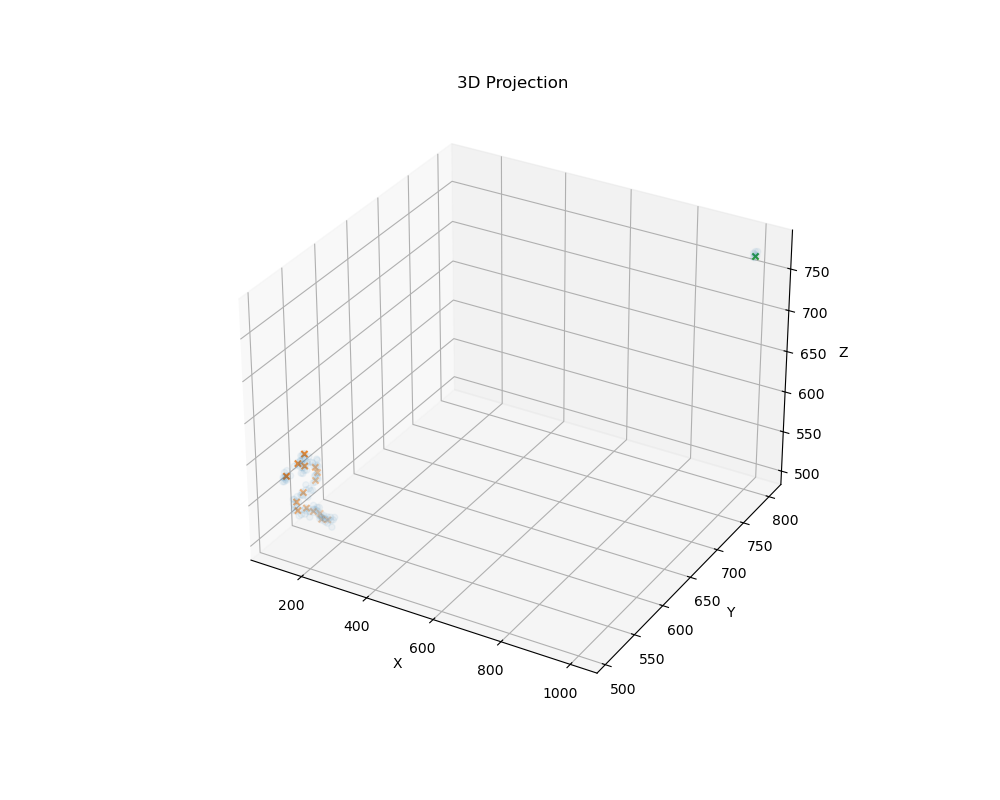

In [35]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

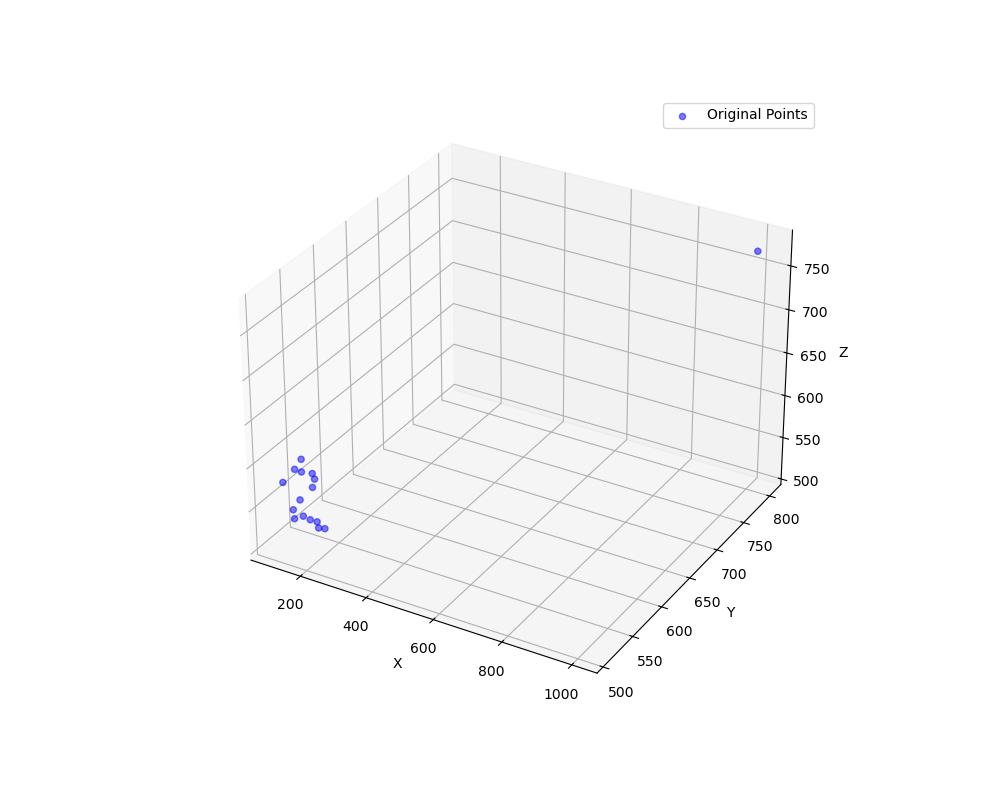

In [36]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [37]:
display(databin)

databin.to_hdf("../data/test/test.h5", "MC/hits")

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,20985011.0,114.0,514.0,580.0,112.434723,511.216064,578.906006,0.107498,0
1,20985011.0,114.0,524.0,540.0,117.352257,522.508362,540.321655,0.208317,0
2,20985011.0,114.0,524.0,590.0,117.895538,526.547180,585.117676,0.337046,0
3,20985011.0,124.0,534.0,550.0,122.019485,530.862061,547.091614,0.131370,0
4,20985011.0,124.0,524.0,530.0,123.559875,521.009399,531.482666,0.105081,0
5,20985011.0,124.0,534.0,580.0,125.430046,532.860046,578.990601,0.247788,0
6,20985011.0,134.0,534.0,600.0,130.706009,530.659363,595.738770,0.305001,0
7,20985011.0,134.0,544.0,570.0,130.087433,546.606079,569.069458,0.155889,0
8,20985011.0,134.0,544.0,550.0,130.093399,546.246338,552.936829,0.232364,0
9,20985011.0,134.0,534.0,530.0,130.662155,530.704956,529.023621,0.087439,0


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_97825/1135446823.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  databin.to_hdf("../data/test/test.h5", "MC/hits")


Diffussion smear is:  0.258 mm/sqrt(cm)
Energy threshold is:  1.0 keV
diffision scale factor is:  5
Radius scale factor is:  7
Voxel scale factor is:  2.1
Tortuosity distance scale is: 23.333333333333332
Median distance to the closest row: 11.582838050456111
Distances to iterate over [ 1  6 12 18 23 29 35 41 46 52 58 63 69 75 81]
Dist Thresh 48.872
Pass Flag: True
The primary track is:  0
      event_id            x           y           z    energy  group_id  id  \
0   20985011.0   130.706009  530.659363  595.738770  0.305001         0  10   
1   20985011.0   112.434723  511.216064  578.906006  0.107498         0   0   
2   20985011.0   117.895538  526.547180  585.117676  0.337046         0   2   
3   20985011.0   125.430046  532.860046  578.990601  0.247788         0   5   
4   20985011.0   130.087433  546.606079  569.069458  0.155889         0   7   
5   20985011.0   129.571930  549.984436  560.317627  0.016396         0   6   
6   20985011.0   130.093399  546.246338  552.936829  0.

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
10,20985011.0,130.706009,530.659363,595.738770,0.305001,0,10,1,0,0.000000,0.000000,1.000000,0.000000e+00
0,20985011.0,112.434723,511.216064,578.906006,0.107498,0,0,1,0,31.547166,97.879283,1.000000,2.549340e-17
2,20985011.0,117.895538,526.547180,585.117676,0.337046,0,2,1,0,48.966938,156.099993,1.148812,3.569560e-01
5,20985011.0,125.430046,532.860046,578.990601,0.247788,0,5,1,0,60.549776,60.332824,1.025615,1.461053e-01
7,20985011.0,130.087433,546.606079,569.069458,0.155889,0,7,1,0,78.130269,26.234998,1.188984,4.722011e-01
6,20985011.0,129.571930,549.984436,560.317627,0.016396,0,6,1,0,87.525671,37.600460,1.095968,2.976723e-01
8,20985011.0,130.093399,546.246338,552.936829,0.232364,0,8,1,0,95.815514,48.412567,1.276574,5.967636e-01
3,20985011.0,122.019485,530.862061,547.091614,0.131370,0,3,1,0,114.146652,50.607358,1.213123,4.645393e-01
1,20985011.0,117.352257,522.508362,540.321655,0.208317,0,1,1,0,125.868411,16.737160,1.742141,1.102438e+00


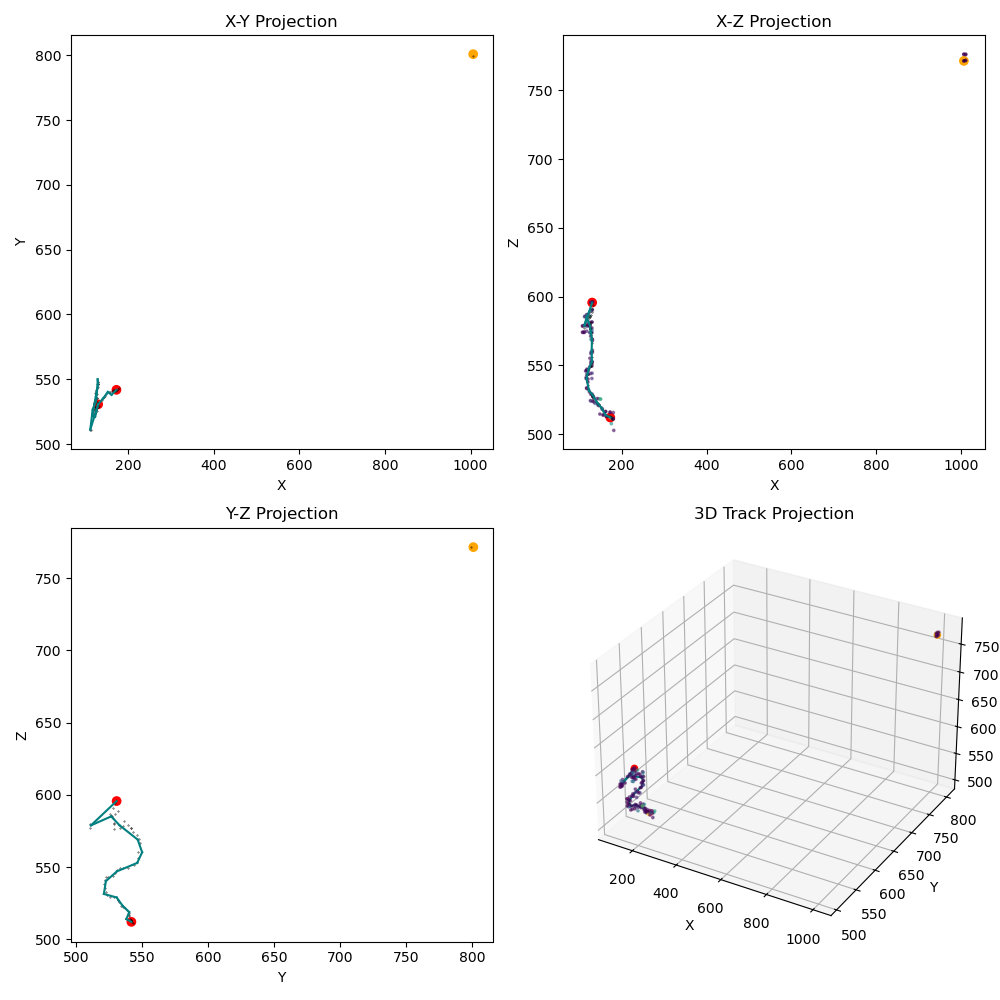

In [38]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
# ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)

plt.tight_layout()
plt.show()

In [39]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,20985011.0,0,1,10,14,198.001,2.341353,0.412498,0.297376,0.305001,0.129401,1.0,1.048511,1.274670e-17,0.197015,Primary
0,20985011.0,1,0,15,15,0.000,0.013506,0.013506,0.013506,0.013506,0.013506,0.0,0.000000,0.000000e+00,0.000000,Brem


Text(0, 0.5, 'Angle')

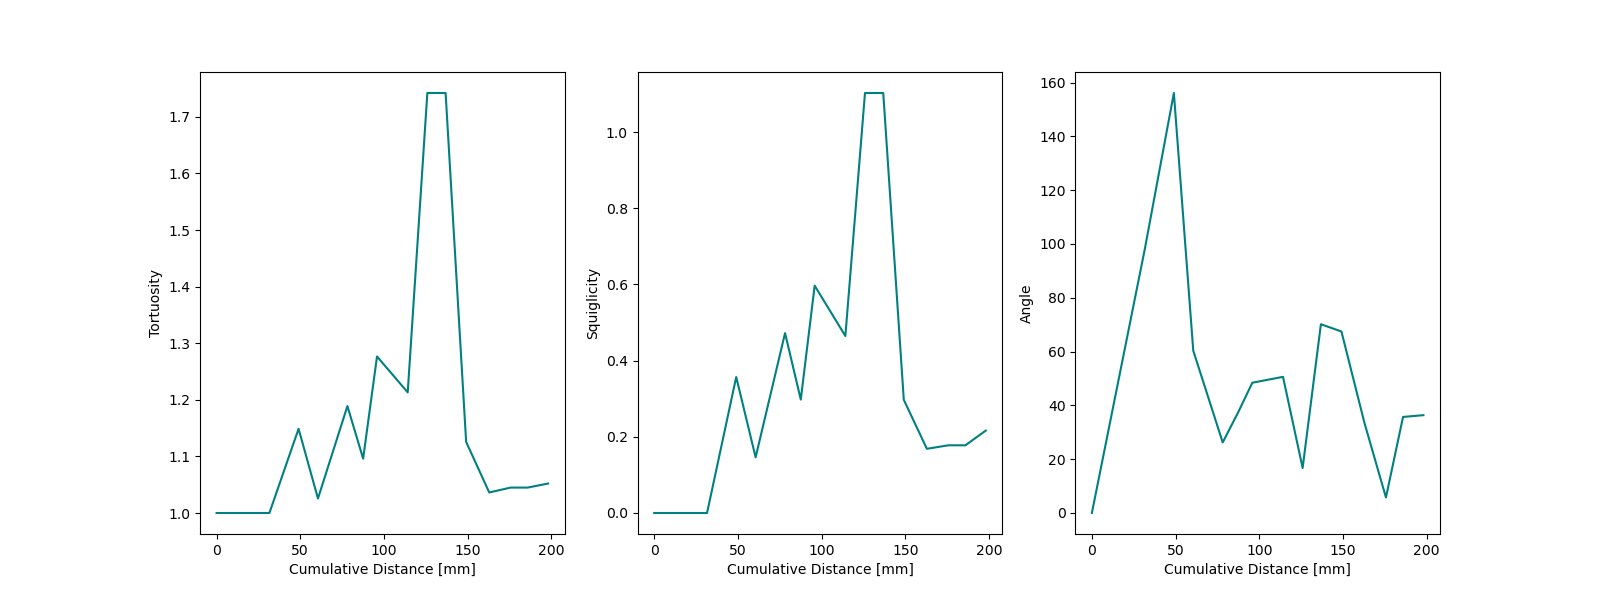

In [40]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"], c="Teal")
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"], c="Teal")
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"], c="Teal")
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle")